# Train the autoencoder with the whole dataset using generators

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg

## Initialize the generator and verify that it works

In [2]:
batch_size = 128
gen_input = dg.SunImgAEGenerator("data/aia_193A/", batch_size, test_split=0.2, shuffle=True, noise_filter=True)

25907
22717


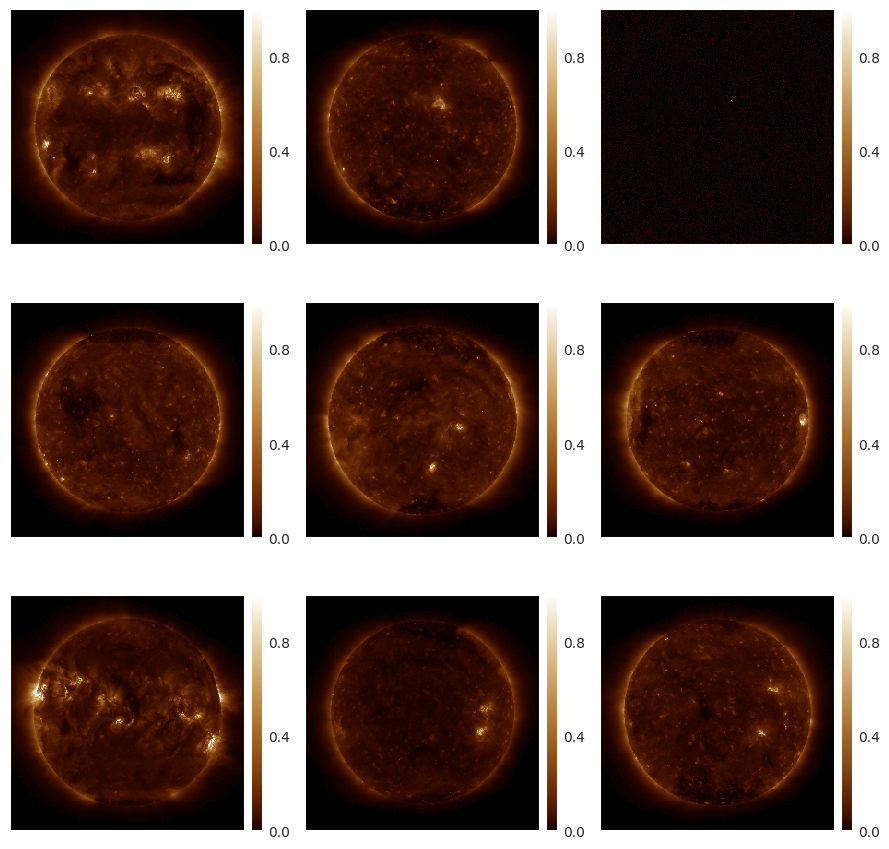

In [3]:
aia193_colormap = cm.color_tables.aia_color_table(193*u.angstrom)
samples = gen_input.sample(9)
isns.ImageGrid([i for i in samples], cmap=aia193_colormap)

## Create and train the model

In [4]:
latent_size = 48
# autoencoder, encoder, decoder = aem.gen_autoenc_model_1c(latent_size, optim="adam", loss="mse")
autoencoder, encoder, decoder = aem.gen_VAE_model_1c(latent_size, optim="adam", loss="mse")

(None,)
(None,)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv2d_1[

In [5]:
n_epochs = 100

gen_input.training = True
history = autoencoder.fit(gen_input, epochs=n_epochs)

Epoch 1/100
 98/403 [======>.......................] - ETA: 1:06 - loss: 0.0077

KeyboardInterrupt: 

## Save the model to a file

In [ ]:
autoencoder.save("autoencoder_193A.h5")
encoder.save("encoder_193A.h5")
decoder.save("decoder_193A.h5")

## Test model and see how it progressed

2023-04-06 21:36:02.956856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


40/40 [==============================] - 121s 3s/step - loss: 0.0012 - mae: 0.0148


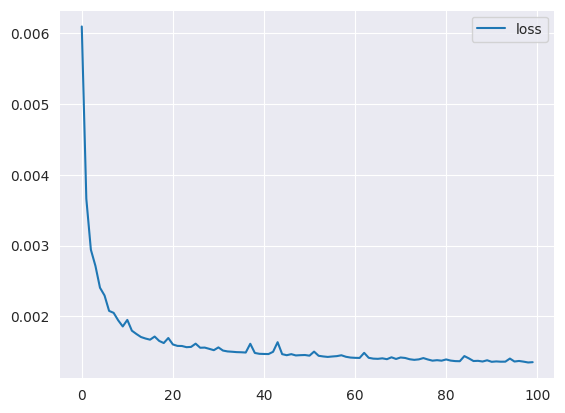

In [ ]:
gen_input.training = False
autoencoder.evaluate(gen_input)
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 249ms/step


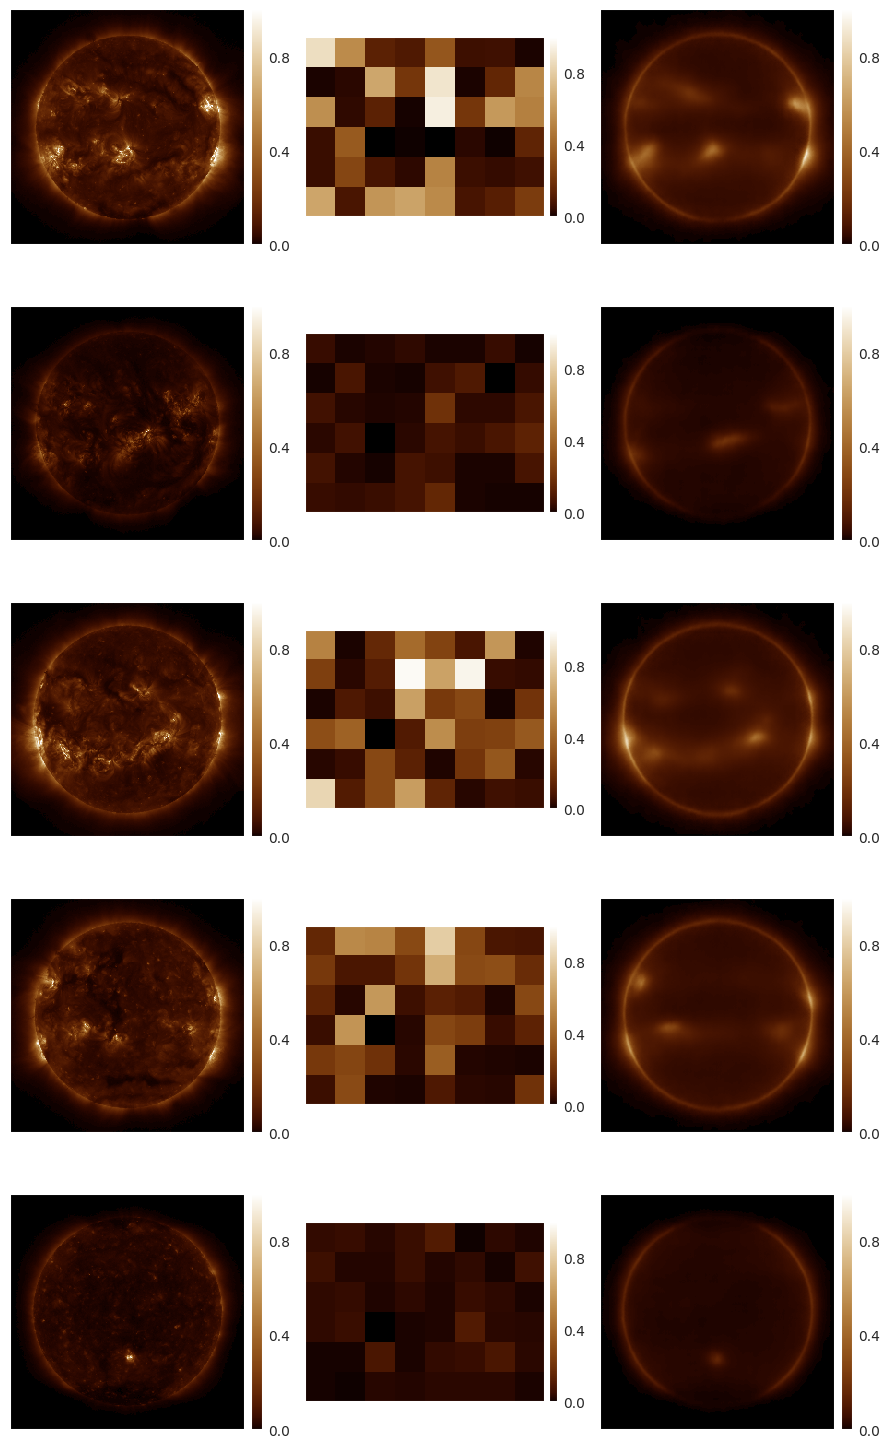

In [ ]:
gen_input.training = False
example = np.array(gen_input[0]).reshape([-1,256,256,1])[:5]
code = encoder.predict(example)
reconstructed = decoder.predict(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(np.reshape(i[1], [6,8]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1)

In [ ]:
autoencoder = keras.models.load_model("autoencoder_193A.h5")
encoder = keras.models.load_model("encoder_193A.h5")
decoder = keras.models.load_model("decoder_193A.h5")
all_data_gen = dg.SunImgAEGenerator("data/aia_193A/", batch_size, test_split=0.2, shuffle=True, noise_filter=False)

1/1 [==============================] - 0s 52ms/step


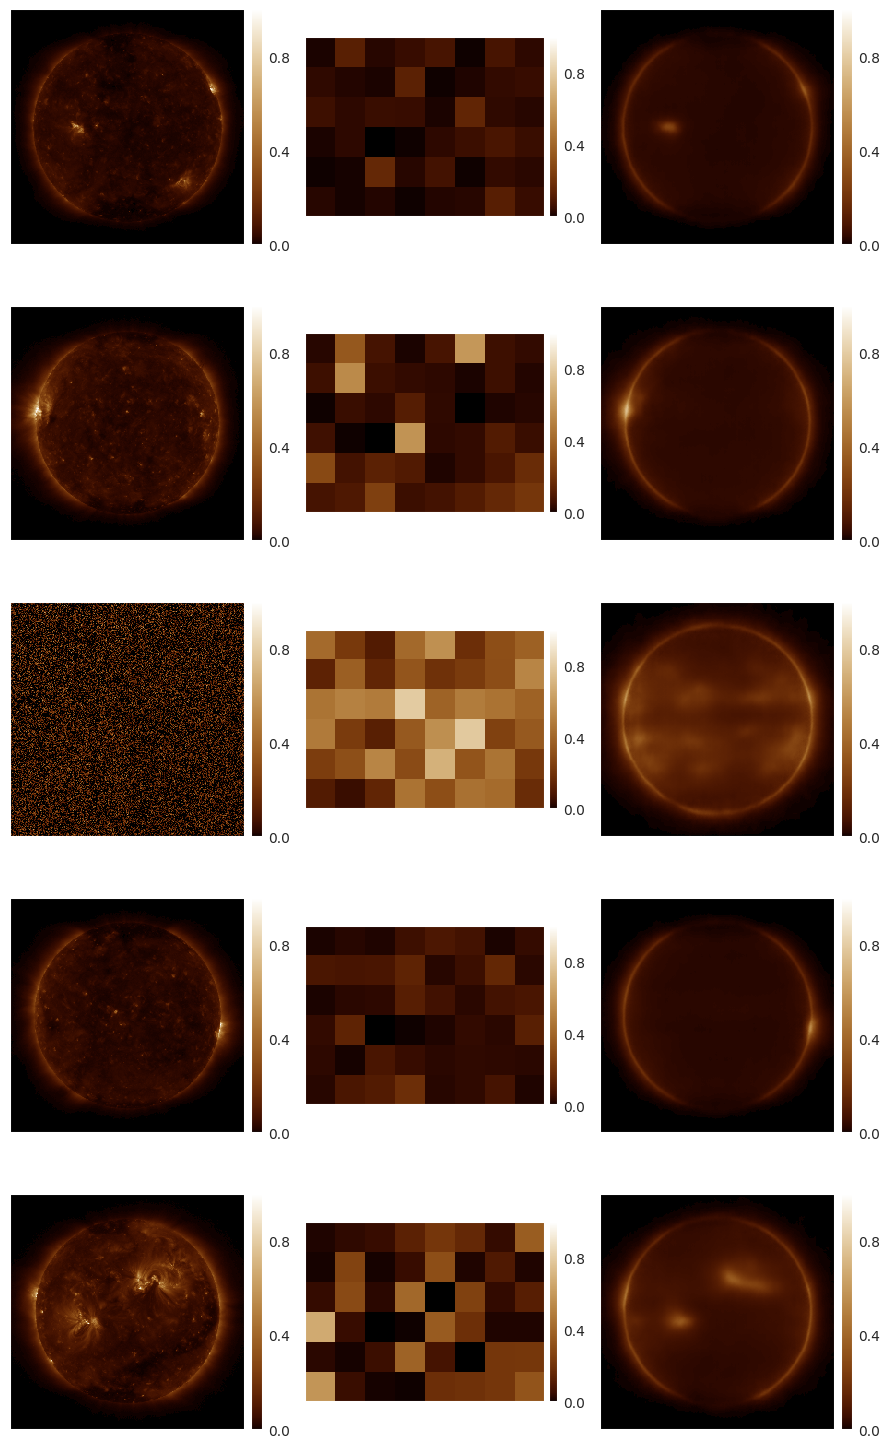

In [ ]:
gen_input.take_all = True
example = all_data_gen.sample(5)
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(np.reshape(i[1], [6,8]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1)

## Test the autoencoder with random inputs

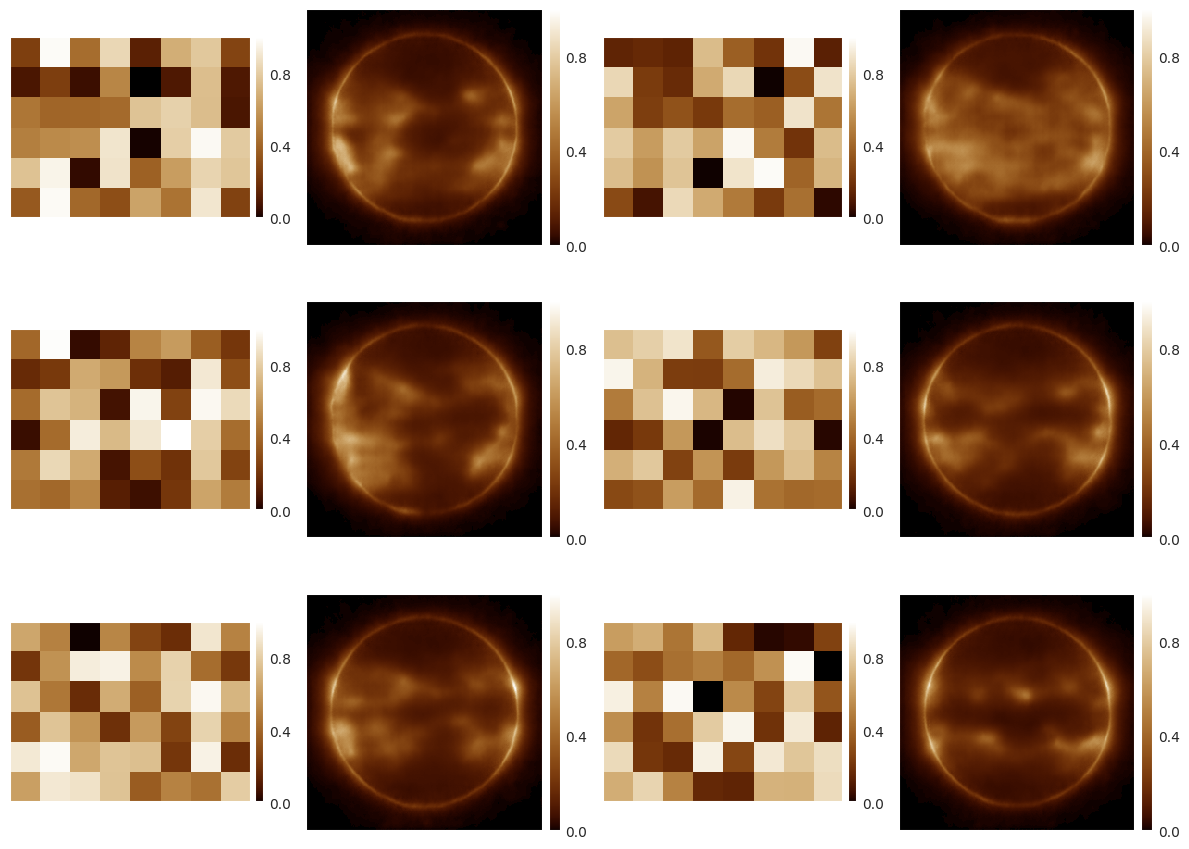

In [ ]:
code = np.random.random([6, 48])
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.reshape(i[0], [6,8]))
    images.append(np.squeeze(i[1]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=4)